In [28]:
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import glob
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings('ignore')


In [29]:
#python process_residential.py --state WA --k 30 --interval 60min --build-parquet --use-parquet

## Helper functions:

In [30]:
def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return np.nan

In [31]:
all_possible_appliances = [
    'Central AC',
    'Clothes Dryer', 
    'Clothes Washer',
    'Dishwasher',
    'Ducted Heatpump',
    'Ductless Heatpump',
    'Electric Baseboard Heaters',
    'Electric Furnace',
    'Electric Resistance Storage Water Heaters',
    'Electric Vehicle Charger',
    'Garbage Disposal',
    'Gas Furnace (Component)',
    'Heat Pump Water Heater',
    'Hot Tub',
    'Instantaneous Water Heater (Elec)',
    'Instantaneous Water Heater (Gas)',
    'Mains',
    'Mains With Solar',
    'Microwave',
    'Needs Review',
    'Other',
    'Other With Solar',
    'Other Zonal Heat',
    'Refrigerator/Freezer',
    'Room AC',
    'Solar',
    'Stove/Oven/Range'
    ]



def shorten_appliance_labels(appliance_names):
    """
    Function to shorten long appliance names for better plot readability
    """
    label_mapping = {
        'Electric Resistance Storage Water Heaters': 'Elec Water Heater',
        'Electric Baseboard Heaters': 'Elec Baseboard',
        'Gas Furnace (Component)': 'Gas Furnace',
        'Heat Pump Water Heater': 'HP Water Heater',
        'Instantaneous Water Heater (Elec)': 'Instant WH (Elec)',
        'Instantaneous Water Heater (Gas)': 'Instant WH (Gas)',
        'Electric Vehicle Charger': 'EV Charger',
        'Refrigerator/Freezer': 'Refrigerator',
        'Stove/Oven/Range': 'Stove/Oven',
        'Garbage Disposal': 'Disposal',
        'Other Zonal Heat': 'Other Heat',
        'Mains With Solar': 'Mains+Solar',
        'Other With Solar': 'Other+Solar',
        'Ductless Heatpump': 'Ductless HP',
        'Ducted Heatpump': 'Ducted HP',
        'Electric Furnace': 'Elec Furnace',
        'Needs Review': 'Unknown'
    }
    
    if isinstance(appliance_names, str):
        return label_mapping.get(appliance_names, appliance_names)
    elif hasattr(appliance_names, '__iter__'):
        return [label_mapping.get(name, name) for name in appliance_names]
    else:
        return appliance_names


In [32]:


def return_days(df:pd.DataFrame):
    monday = df[df['dow']==0].groupby('hour')['total_kW'].mean()
    tuesday = df[df['dow']==1].groupby('hour')['total_kW'].mean()
    wednesday = df[df['dow']==2].groupby('hour')['total_kW'].mean()
    thursday = df[df['dow']==3].groupby('hour')['total_kW'].mean()
    friday = df[df['dow']==4].groupby('hour')['total_kW'].mean()
    saturday = df[df['dow']==5].groupby('hour')['total_kW'].mean()
    sunday = df[df['dow']==6].groupby('hour')['total_kW'].mean()

    return monday, tuesday, wednesday, thursday, friday, saturday, sunday


## Load data:


In [33]:


# Path to the base directory
base_path = "residential/processed/WA"


csv_paths = glob.glob(os.path.join(base_path, "*/loads/data_pivot_60min.csv"))

# Load both load and temperature files
site_data = {}

for site_path in glob.glob(os.path.join(base_path, "*")):
    site_id = os.path.basename(site_path)
    load_path = os.path.join(site_path, "loads/data_pivot_60min.csv")
    temp_path = os.path.join(site_path, "temps/temperature_pivot_60min.csv")
    weather_path = os.path.join(site_path, "weather/weather_station.csv")

    if os.path.exists(load_path):
        load_df = pd.read_csv(load_path)
        temp_df = pd.read_csv(temp_path) if os.path.exists(temp_path) else None
        weather_df = pd.read_csv(weather_path) if os.path.exists(weather_path) else None
        site_data[site_id] = {"load": load_df, "temp": temp_df, "weather": weather_df}
        print(f"Loaded site {site_id}")

print(f'\nloaded {len(site_data)} sites')



Loaded site 9036
Loaded site 10406
Loaded site 6471
Loaded site 9006
Loaded site 132997
Loaded site 11116
Loaded site 9251
Loaded site 4576
Loaded site 6441
Loaded site 113763
Loaded site 117592
Loaded site 639673
Loaded site 6991
Loaded site 8661
Loaded site 4631
Loaded site 4201
Loaded site 141373
Loaded site 10120
Loaded site 4461
Loaded site 158234
Loaded site 177845
Loaded site 397168
Loaded site 10746
Loaded site 3446
Loaded site 1786
Loaded site 10936
Loaded site 10931
Loaded site 144417
Loaded site 10706
Loaded site 308069
Loaded site 851
Loaded site 4481
Loaded site 152143
Loaded site 634231
Loaded site 9041
Loaded site 183932
Loaded site 317951
Loaded site 241834
Loaded site 101197
Loaded site 10014
Loaded site 197303
Loaded site 976
Loaded site 627821
Loaded site 197783
Loaded site 4741
Loaded site 1001
Loaded site 179433
Loaded site 10068
Loaded site 732
Loaded site 10466
Loaded site 1065
Loaded site 11380
Loaded site 254366
Loaded site 650217
Loaded site 4851
Loaded site 6

In [35]:
# Select site

selected_site = '1001'

df = site_data[selected_site]
df = df['load']
temp = site_data[selected_site]
temp = temp['temp']
weather = site_data[selected_site]
weather = weather['weather']


In [36]:
# Select season

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(get_season)

summer_df = df[df['season']=='Summer']
winter_df = df[df['season']=='Winter']
spring_df = df[df['season']=='Spring']
fall_df = df[df['season']=='Fall']


seasons = {
    'Summer' : summer_df,
    'Spring' : spring_df,
    'Winter' : winter_df,
    'Fall'  : fall_df
}

selected_season = 'Summer'

season_df = seasons[selected_season]

print(f'Loaded season {selected_season}')

Loaded season Summer


## Seasonal analysis:


 average seasonal load:
season
Fall      1.130760
Spring    1.435366
Summer    0.798502
Winter    1.940721
Name: total_kW, dtype: float64


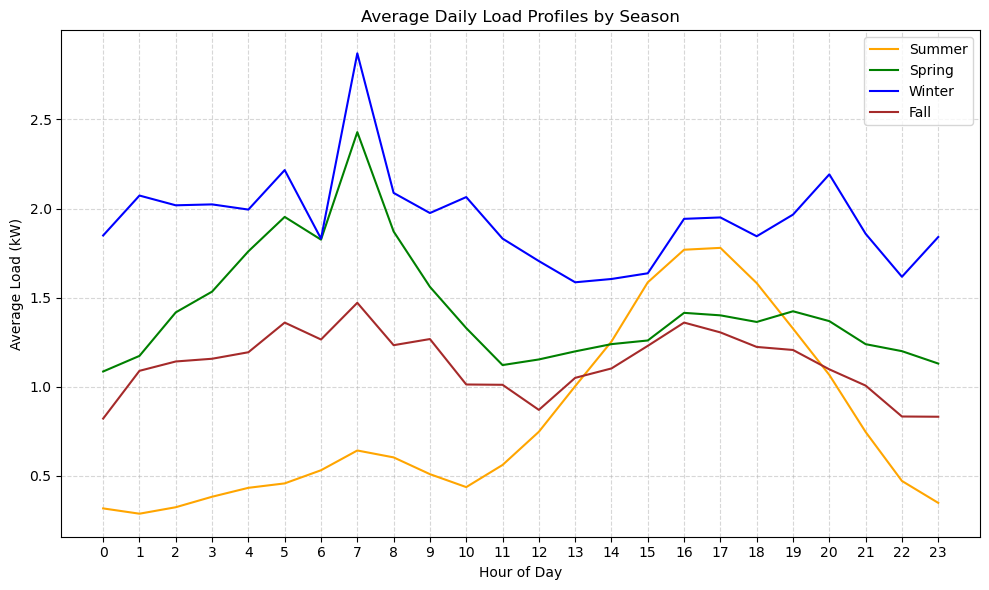

In [40]:
def seasonal_changes(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    
        
    df['season'] = df['month'].apply(get_season)
    average_seasonal = df.groupby('season')['total_kW'].mean()
    

    print('\n average seasonal load:')
    print(average_seasonal)

    summer = df[df['season'] == 'Summer'] 
    average_summer_day = summer.groupby('hour')['total_kW'].mean()

    spring = df[df['season'] == 'Spring']
    average_spring_day = spring.groupby('hour')['total_kW'].mean()

    winter = df[df['season'] == 'Winter']
    average_winter_day = winter.groupby('hour')['total_kW'].mean()

    fall = df[df['season'] == 'Fall']
    average_fall_day = fall.groupby('hour')['total_kW'].mean()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(average_summer_day.index, average_summer_day.values, label='Summer', color='orange')
    plt.plot(average_spring_day.index, average_spring_day.values, label='Spring', color='green')
    plt.plot(average_winter_day.index, average_winter_day.values, label='Winter', color='blue')
    plt.plot(average_fall_day.index, average_fall_day.values, label='Fall', color='brown')
    plt.title('Average Daily Load Profiles by Season')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Load (kW)')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



seasonal_changes(df)

Most frequent peak hour across days: 17


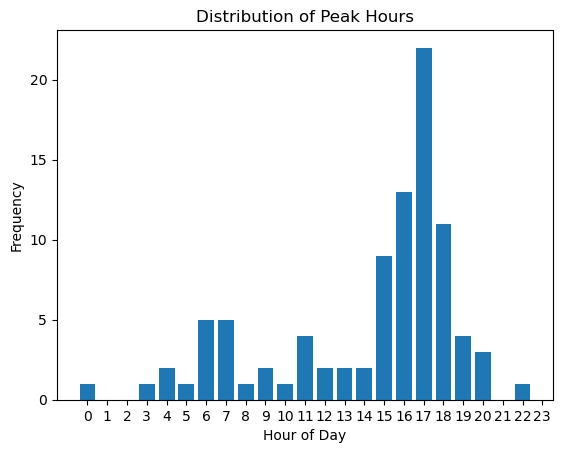

In [41]:
def peak_hour_barplot(df: pd.DataFrame):
    daily_peaks = df.loc[df.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour"]].reset_index(drop=True)
    daily_peaks.rename(columns={"total_kW": "daily_peak_kW", "hour": "peak_hour"}, inplace=True)
    df = df.merge(daily_peaks,on='date',how = 'left')
    peak_hours = df.loc[df["total_kW"] == df["daily_peak_kW"], "hour"]
    print("Most frequent peak hour across days:", peak_hours.mode().iloc[0])
    

    #plot
    plt.Figure(figsize=(12,6))
    plt.bar(peak_hours.value_counts().sort_index().index,peak_hours.value_counts().sort_index().values)
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.title('Distribution of Peak Hours')
    plt.xticks(range(0,24))
    plt.show()

peak_hour_barplot(season_df)

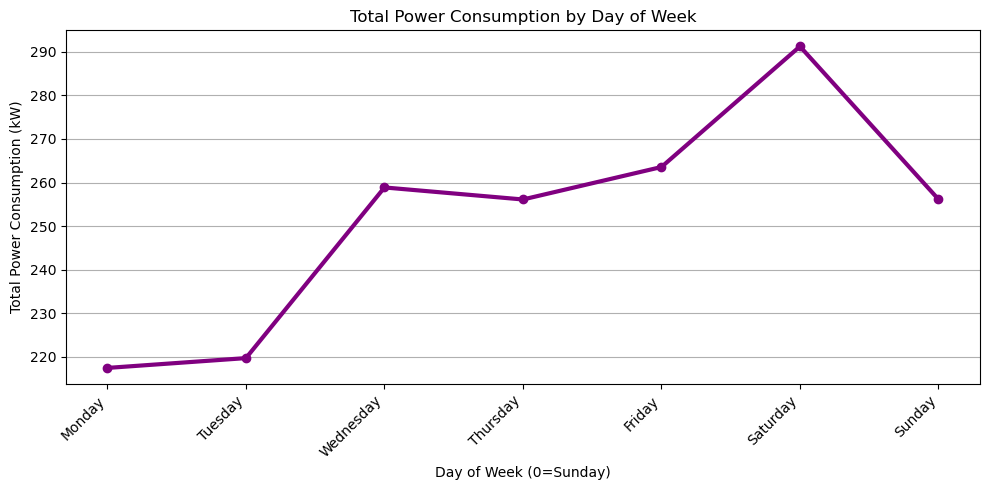

Days with most consumption ranked:

   total_kW        day
0   291.226   Saturday
1   263.558     Friday
2   258.867  Wednesday
3   256.153     Sunday
4   256.107   Thursday
5   219.717    Tuesday
6   217.465     Monday


In [42]:
def dow_with_most_consumption(df : pd.DataFrame):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
    dow_consumption = df.groupby('dow')['total_kW'].sum().reset_index()
    dow_consumption['day'] = dow_consumption['dow'].apply(lambda x: days[x])

    plt.figure(figsize=(10,5))
    plt.plot(days, dow_consumption['total_kW'], color='purple',marker='o', linewidth = 3)
    plt.xlabel('Day of Week (0=Sunday)')
    plt.ylabel('Total Power Consumption (kW)')
    plt.title('Total Power Consumption by Day of Week')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


    print('Days with most consumption ranked:\n')
    print(dow_consumption[['total_kW','day']].sort_values(by='total_kW',ascending=False).reset_index(drop=True))



dow_with_most_consumption(season_df)

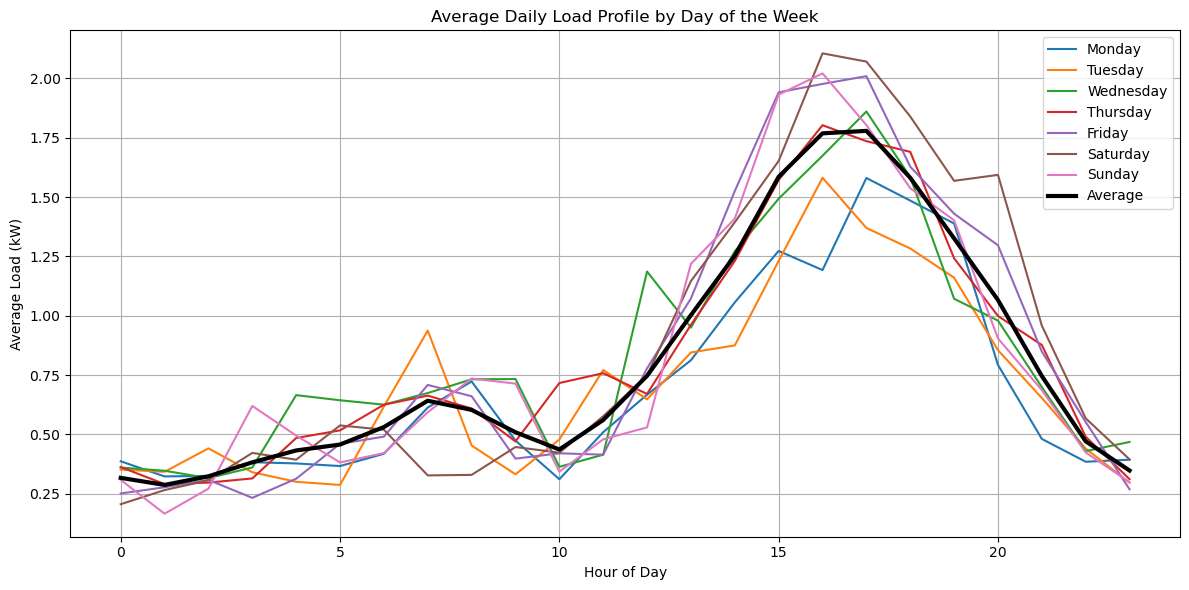

Peak hour for each day:
Monday: 17:00 with 1.58 kW
Tuesday: 16:00 with 1.58 kW
Wednesday: 17:00 with 1.86 kW
Thursday: 16:00 with 1.80 kW
Friday: 17:00 with 2.01 kW
Saturday: 16:00 with 2.11 kW
Sunday: 16:00 with 2.02 kW
Hour with the highest peak across all days: 16:00 with 2.11 kW


In [43]:
def day_profile(df:pd.DataFrame):
    monday, tuesday, wednesday, thursday, friday, saturday, sunday = return_days(df)
    

    plt.figure(figsize=(12, 6))
    plt.plot(monday.index, monday.values, label='Monday')
    plt.plot(tuesday.index, tuesday.values, label='Tuesday')
    plt.plot(wednesday.index, wednesday.values, label='Wednesday')
    plt.plot(thursday.index, thursday.values, label='Thursday')
    plt.plot(friday.index, friday.values, label='Friday')
    plt.plot(saturday.index, saturday.values, label='Saturday')
    plt.plot(sunday.index, sunday.values, label='Sunday')
    plt.plot(df.groupby('hour')['total_kW'].mean().index, df.groupby('hour')['total_kW'].mean().values, label='Average', linewidth=3, color='black')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Load (kW)')
    plt.title('Average Daily Load Profile by Day of the Week')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()  


    monday_peak = monday.idxmax()
    tuesday_peak = tuesday.idxmax()
    wednesday_peak = wednesday.idxmax()
    thursday_peak = thursday.idxmax()
    friday_peak = friday.idxmax()
    saturday_peak = saturday.idxmax()
    sunday_peak = sunday.idxmax()

    highest_peak_day =  max(monday_peak, tuesday_peak, wednesday_peak, thursday_peak, friday_peak, saturday_peak, sunday_peak)
    highest_peak_hour = (monday_peak if monday.max() == max(monday.max(), tuesday.max(), wednesday.max(), thursday.max(), friday.max(), saturday.max(), sunday.max()) else
                         tuesday_peak if tuesday.max() == max(monday.max(), tuesday.max(), wednesday.max(), thursday.max(), friday.max(), saturday.max(), sunday.max()) else
                         wednesday_peak if wednesday.max() == max(monday.max(), tuesday.max(), wednesday.max(), thursday.max(), friday.max(), saturday.max(), sunday.max()) else
                         thursday_peak if thursday.max() == max(monday.max(), tuesday.max(), wednesday.max(), thursday.max(), friday.max(), saturday.max(), sunday.max()) else
                         friday_peak if friday.max() == max(monday.max(), tuesday.max(), wednesday.max(), thursday.max(), friday.max(), saturday.max(), sunday.max()) else
                         saturday_peak if saturday.max() == max(monday.max(), tuesday.max(), wednesday.max(), thursday.max(), friday.max(), saturday.max(), sunday.max()) else
                         sunday_peak)
    print('Peak hour for each day:')
    print(f'Monday: {monday_peak}:00 with {monday.max():.2f} kW')
    print(f'Tuesday: {tuesday_peak}:00 with {tuesday.max():.2f} kW')
    print(f'Wednesday: {wednesday_peak}:00 with {wednesday.max():.2f} kW')
    print(f'Thursday: {thursday_peak}:00 with {thursday.max():.2f} kW')
    print(f'Friday: {friday_peak}:00 with {friday.max():.2f} kW')
    print(f'Saturday: {saturday_peak}:00 with {saturday.max():.2f} kW')
    print(f'Sunday: {sunday_peak}:00 with {sunday.max():.2f} kW')
    print(f'Hour with the highest peak across all days: {highest_peak_hour}:00 with {max(monday.max(), tuesday.max(), wednesday.max(), thursday.max(), friday.max(), saturday.max(), sunday.max()):.2f} kW')
day_profile(season_df)

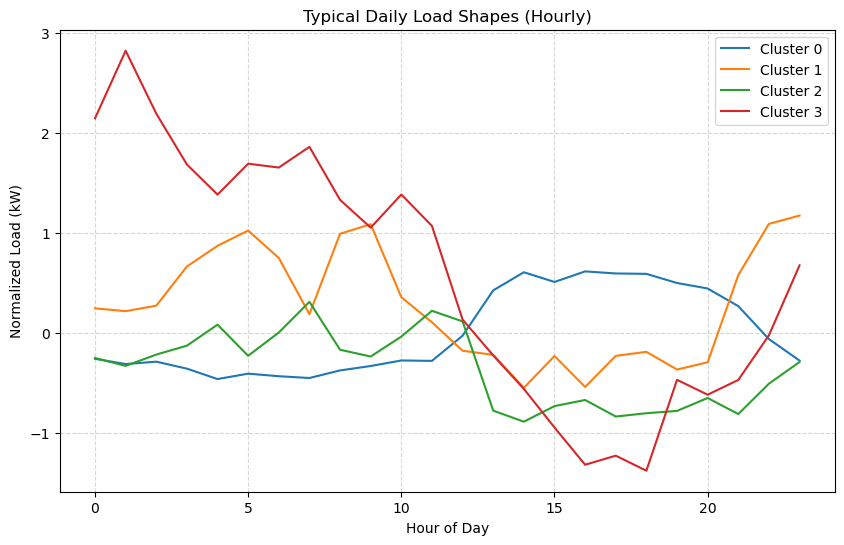


Days per cluster:
cluster
0    50
2    22
1    13
3     7
Name: count, dtype: int64


In [44]:
def day_timeseries_cluster(df: pd.DataFrame, n_cluster: int):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

   
    daily_profiles = (
        df.pivot_table(index='date', columns='hour', values='total_kW', aggfunc='mean')
        .fillna(0)
    )

    
    daily_profiles_norm = daily_profiles.div(daily_profiles.max(axis=1), axis=0).fillna(0)

    
    scaler = StandardScaler()
    daily_scaled = pd.DataFrame(
        scaler.fit_transform(daily_profiles_norm),
        index=daily_profiles_norm.index,
        columns=daily_profiles_norm.columns
    )

    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)
    daily_scaled['cluster'] = kmeans.fit_predict(daily_scaled)

   
    plt.figure(figsize=(10, 6))
    cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=daily_profiles.columns)

    for i, row in cluster_centers.iterrows():
        plt.plot(row.index, row.values, label=f'Cluster {i}')

    plt.title("Typical Daily Load Shapes (Hourly)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Normalized Load (kW)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    
    print("\nDays per cluster:")
    print(daily_scaled['cluster'].value_counts())
    

    df_clusters = pd.DataFrame({'date': daily_scaled.index, 'cluster': daily_scaled['cluster']})
    df_clusters.rename_axis("index", inplace=True)
    df = df.merge(df_clusters, left_on='date', right_on='date', how='left', suffixes=('', '_clustered'))

    df = df.rename_axis("index")

day_timeseries_cluster(season_df, n_cluster= 4)

In [ ]:
def appliance_correlation_at_peak_hours(df: pd.DataFrame, desired_day: str):
    """
    Function to create correlation matrices for appliances at peak hours for each day
    """
    # Get available appliances in the dataset
    appliances = [appliance for appliance in all_possible_appliances if appliance in df.columns]
    
    
    # Ensure we have timestamp and date columns
    if 'timestamp' in df.columns:
        df['date'] = pd.to_datetime(df['timestamp']).dt.date
    df['date'] = pd.to_datetime(df['date'])
    
    # Find daily peaks
    #daily_peaks = df.loc[df.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)
    #daily_peaks.rename(columns={"total_kW": "daily_peak_kW", "hour": "peak_hour"}, inplace=True)
    monday = df[df['dow'] == 0]
    tuesday = df[df['dow'] == 1]
    wednesday = df[df['dow'] == 2]
    thursday = df[df['dow'] == 3]
    friday = df[df['dow'] == 4]
    saturday = df[df['dow'] == 5]
    sunday = df[df['dow'] == 6]


    monday = monday.loc[monday.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)
    tuesday = tuesday.loc[tuesday.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)
    wednesday = wednesday.loc[wednesday.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)
    thursday = thursday.loc[thursday.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)
    friday = friday.loc[friday.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)
    saturday = saturday.loc[saturday.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)
    sunday = sunday.loc[sunday.groupby("date")["total_kW"].idxmax()][["date", "total_kW", "hour",'dow'] + [x for x in appliances]].reset_index(drop=True)

    corr_monday = monday[appliances + ['total_kW']].corr()
    corr_tuesday = tuesday[appliances + ['total_kW']].corr()
    corr_wednesday = wednesday[appliances + ['total_kW']].corr()
    corr_thursday = thursday[appliances + ['total_kW']].corr()
    corr_friday = friday[appliances + ['total_kW']].corr()
    corr_saturday = saturday[appliances + ['total_kW']].corr()
    corr_sunday = sunday[appliances + ['total_kW']].corr()
    print("Correlation matrices for appliances at desired day:")
    if desired_day.lower() == 'monday':
        print(corr_monday['total_kW'].sort_values(ascending=False))
    elif desired_day.lower() == 'tuesday':
        print(corr_tuesday['total_kW'].sort_values(ascending=False))
    elif desired_day.lower() == 'wednesday':    
        print(corr_wednesday['total_kW'].sort_values(ascending=False))
    elif desired_day.lower() == 'thursday':
        print(corr_thursday['total_kW'].sort_values(ascending=False))
    elif desired_day.lower() == 'friday':
        print(corr_friday['total_kW'].sort_values(ascending=False))
    elif desired_day.lower() == 'saturday':
        print(corr_saturday['total_kW'].sort_values(ascending=False))
    elif desired_day.lower() == 'sunday':
        print(corr_sunday['total_kW'].sort_values(ascending=False))
    else:
        print("Invalid day provided. Please choose from: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday.")
    


appliance_correlation_at_peak_hours(season_df,'Friday')

Correlation matrices for appliances at desired day:
total_kW                                     1.000000
Clothes Dryer                                0.723280
Other                                        0.611131
Other Zonal Heat                             0.350453
Electric Resistance Storage Water Heaters    0.261615
Garbage Disposal                             0.225712
Solar                                       -0.066605
Ductless Heatpump                           -0.203258
Dishwasher                                  -0.440648
Name: total_kW, dtype: float64


-0.1807528964862298


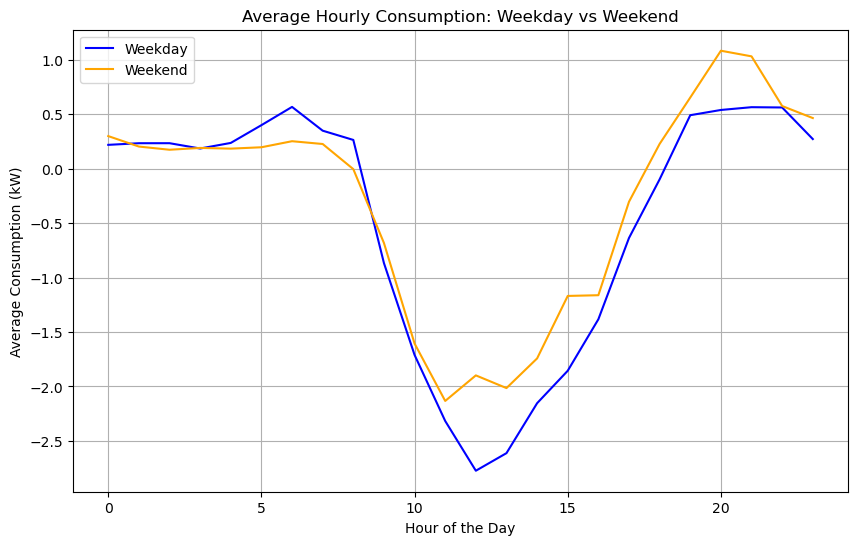

In [ ]:
def weekend_vs_weekday_consumption(df : pd.DataFrame):
    weekday = df[df['is_weekend']==0]
    weekend = df[df['is_weekend']==1]

    weekday = weekday.groupby('hour')['total_kW'].mean()
    weekend = weekend.groupby('hour')['total_kW'].mean()

    difference = sum(weekday-weekend)/24 
    print(difference)

    plt.figure(figsize=(10,6))
    plt.plot(weekday.index, weekday.values, label='Weekday', color='blue')
    plt.plot(weekend.index, weekend.values, label='Weekend', color='orange')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Consumption (kW)')
    plt.title('Average Hourly Consumption: Weekday vs Weekend')
    plt.legend()
    plt.grid()
    plt.show()


weekend_vs_weekday_consumption(season_df)

In [ ]:
def day_vs_night_consumption(df: pd.DataFrame):
    day_time = df[(df['hour'] >= 7) & (df['hour'] < 19)]
    night_time = df[(df['hour'] < 7) | (df['hour'] >= 19)]
    day_avg = day_time['total_kW'].mean()
    night_avg = night_time['total_kW'].mean()
    print(f"Average Daytime Consumption (7AM-6PM): {day_avg:.3f} kW/h")
    print(f"Average Nighttime Consumption (6PM-7AM): {night_avg:.3f} kW/h")
    print(f"Daytime to Nighttime Consumption Ratio: {day_avg/night_avg:.2f}")
   

day_vs_night_consumption(season_df)

Average Daytime Consumption (7AM-6PM): -1.230 kW/h
Average Nighttime Consumption (6PM-7AM): 0.395 kW/h
Daytime to Nighttime Consumption Ratio: -3.11


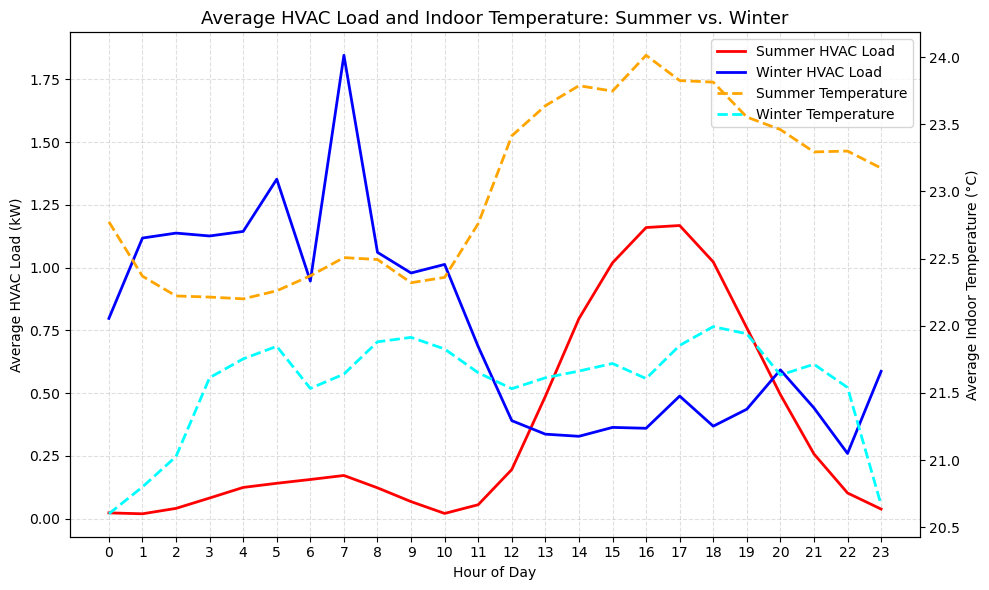

In [45]:
def hvac_seasonal_changes_with_temp(df: pd.DataFrame,temperature:pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['season'] = df['month'].apply(get_season)
    summer = df[df['season']=='Summer']
    winter = df[df['season']=='Winter'] 



    average_hvac_summer = summer.groupby('hour')['hvac_total_kW'].mean()
    average_hvac_winter = winter.groupby('hour')['hvac_total_kW'].mean()

    temperature['T1_TX1'] = temperature['T1_TX1'].round(1)
    temperature['Indoor_Temp_C'] = temperature['T1_TX1']
    temperature = temperature.drop(columns=['T1_TX1'])

    temperature['date'] = pd.to_datetime(temperature['date'])
    temperature['month'] = temperature['date'].dt.month
    temperature['season'] = temperature['month'].apply(get_season)

    temp_summer = temperature[temperature['season']=='Summer']
    temp_summer_day = temp_summer.groupby('hour')['Indoor_Temp_C'].mean()

    temp_winter = temperature[temperature['season'] == 'Winter']
    temp_winter_day = temp_winter.groupby('hour')['Indoor_Temp_C'].mean()


    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()  # first axis (HVAC load)

    # Plot HVAC load
    ax1.plot(average_hvac_summer.index, average_hvac_summer.values, label='Summer HVAC Load', color='red', linewidth=2)
    ax1.plot(average_hvac_winter.index, average_hvac_winter.values, label='Winter HVAC Load', color='blue', linewidth=2)
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Average HVAC Load (kW)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xticks(range(0, 24))
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Create secondary y-axis for temperature
    ax2 = ax1.twinx()

    # Plot temperature curves
    ax2.plot(temp_summer_day.index, temp_summer_day.values, label='Summer Temperature', color='orange', linestyle='--', linewidth=2)
    ax2.plot(temp_winter_day.index, temp_winter_day.values, label='Winter Temperature', color='cyan', linestyle='--', linewidth=2)
    ax2.set_ylabel('Average Indoor Temperature (°C)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.title('Average HVAC Load and Indoor Temperature: Summer vs. Winter', fontsize=13)
    plt.tight_layout()
    plt.show()


hvac_seasonal_changes_with_temp(df,temp)

In [46]:
weather_df['min_t'] = pd.to_datetime(weather_df['min_t'])
weather_df['max_t'] = pd.to_datetime(weather_df['max_t'])

# Option 1: Use start time's hour
weather_df['hour'] = weather_df['min_t'].dt.hour


# Option 2: Use the midpoint between start and end times
weather_df['mid_t'] = weather_df['min_t'] + (weather_df['max_t'] - weather_df['min_t']) / 2
weather_df['hour_mid'] = weather_df['mid_t'].dt.hour
weather_df['date'] = weather_df['mid_t'].dt.date

weather_df = weather_df.sort_values(by=['date', 'hour_mid']).reset_index(drop=True)


df['date'] = pd.to_datetime(df['date']).dt.date

df_weather_merged = pd.merge(
    df,
    weather_df[['wind_spd', 'temp', 'temp_f', 'dew_point', 'atm_pres', 'date', 'hour_mid']],
    left_on=['date', 'hour'],
    right_on=['date', 'hour_mid'],
    how='left'
)
df_weather_merged[['date','hour','temp','hvac_total_kW']].head()

,date,hour,temp,hvac_total_kW
0,2024-01-01,0,7.5,0.006
1,2024-01-01,1,6.0,2.077
2,2024-01-01,1,6.0,2.077
3,2024-01-01,1,6.0,2.077
4,2024-01-01,1,6.0,2.077


     season        date  hvac_total_kW       temp
183  Summer  2024-06-01       0.106417  15.748056
184  Summer  2024-06-02       0.026875  15.154948
185  Summer  2024-06-03       0.019083  13.345551
186  Summer  2024-06-04       0.095875  12.988268
187  Summer  2024-06-05       0.185667  12.397721
..      ...         ...            ...        ...
265  Summer  2024-08-22       0.067458  17.218542
266  Summer  2024-08-23       0.011000  16.079485
267  Summer  2024-08-24       0.101333  13.866446
268  Summer  2024-08-25       0.227167  15.189658
269  Summer  2024-08-26       0.273250  16.767197

[87 rows x 4 columns]
Summer data shapes - X: (91, 1), y: (91,)
Summer - Mean Squared Error: 0.019
Summer - R-squared: 0.635


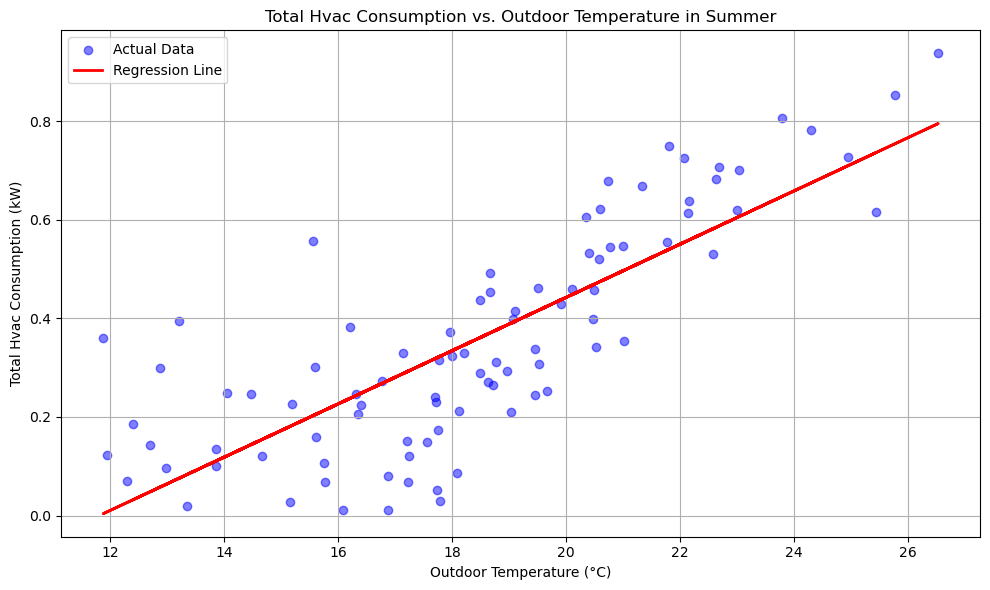

Winter data shapes - X: (89, 1), y: (89,)
Winter - Mean Squared Error: 0.066
Winter - R-squared: 0.805


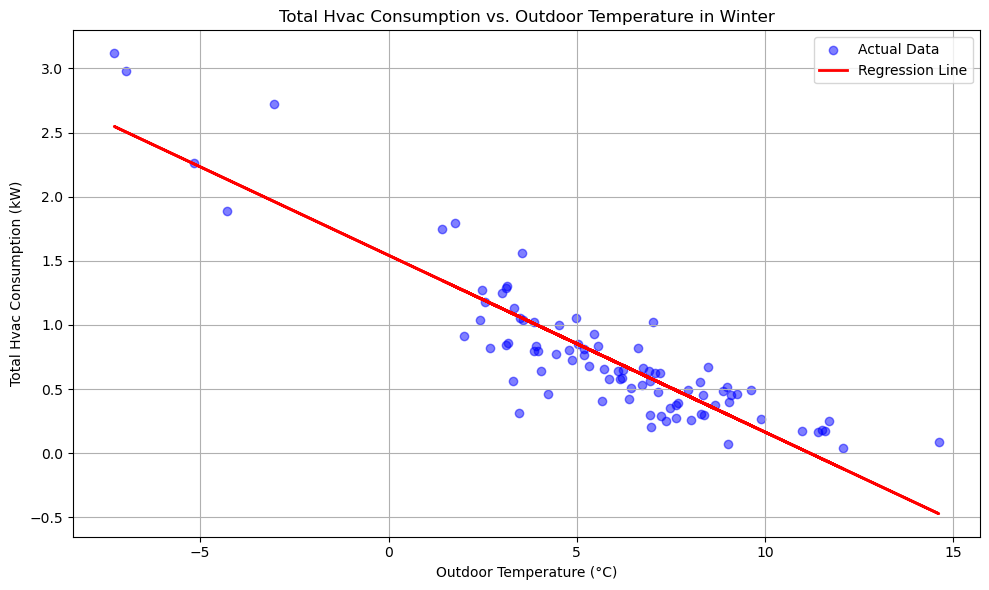

In [49]:
def temp_hvac_regression(df: pd.DataFrame, weather_df: pd.DataFrame):
    

    weather_df = weather_df.groupby('date')['temp'].mean().reset_index()


    df = df.groupby(['season','date'])['hvac_total_kW'].mean().reset_index()

    df_weather_merged = pd.merge(
        df,
        weather_df[['temp','date']],
        on='date',
        how='left'
    )
    


    summer = df_weather_merged[df_weather_merged['season'] =='Summer']  
    winter = df_weather_merged[df_weather_merged['season'] =='Winter']
    print(summer.head(-5))
  

    # Summer linear regression - ensure same shape by dropping NaN together
    summer_clean = summer[['temp', 'hvac_total_kW']].dropna()
    summer_clean = summer_clean[summer_clean['hvac_total_kW'] > 0]
    X_summer = summer_clean[['temp']]
    y_summer = summer_clean['hvac_total_kW']
    print(f"Summer data shapes - X: {X_summer.shape}, y: {y_summer.shape}")
    
    
    model = LinearRegression()
    model.fit(X_summer, y_summer)
    y_pred = model.predict(X_summer)
    mse = mean_squared_error(y_summer, y_pred)
    r2 = r2_score(y_summer, y_pred)
    print(f"Summer - Mean Squared Error: {mse:.3f}")
    print(f"Summer - R-squared: {r2:.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_summer, y_summer, color='blue', alpha=0.5, label='Actual Data')
    plt.plot(X_summer, y_pred, color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Outdoor Temperature (°C)')
    plt.ylabel('Total Hvac Consumption (kW)')
    plt.title('Total Hvac Consumption vs. Outdoor Temperature in Summer')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Winter linear regression - ensure same shape by dropping NaN together
    winter_clean = winter[['temp', 'hvac_total_kW']].dropna()
    winter_clean = winter_clean[winter_clean['hvac_total_kW'] > 0]
    X_winter = winter_clean[['temp']]
    y_winter = winter_clean['hvac_total_kW']
    print(f"Winter data shapes - X: {X_winter.shape}, y: {y_winter.shape}")
    
    model_winter = LinearRegression()
    model_winter.fit(X_winter, y_winter)
    y_pred_winter = model_winter.predict(X_winter)
    mse_winter = mean_squared_error(y_winter, y_pred_winter)
    r2_winter = r2_score(y_winter, y_pred_winter)
    print(f"Winter - Mean Squared Error: {mse_winter:.3f}")
    print(f"Winter - R-squared: {r2_winter:.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_winter, y_winter, color='blue', alpha=0.5, label='Actual Data')
    plt.plot(X_winter, y_pred_winter, color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Outdoor Temperature (°C)')
    plt.ylabel('Total Hvac Consumption (kW)')
    plt.title('Total Hvac Consumption vs. Outdoor Temperature in Winter')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

temp_hvac_regression(df,weather_df)

   dew_point  hvac_total_kW
0        6.0          0.544
1        6.0          0.549
2        5.0          0.549
3        6.0          0.549
4        5.0          0.549
Dew Point - Mean Squared Error: 0.025
Dew Point - R-squared: 0.444


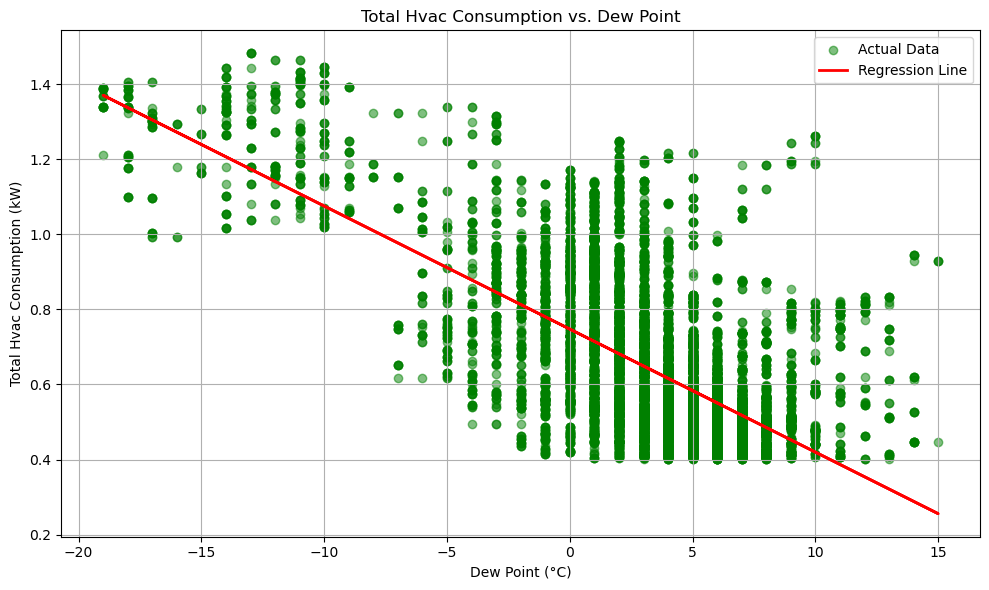

In [ ]:
def dewpoint_vs_hvac(df:pd.DataFrame,weather:pd.DataFrame):
    df['date'] = pd.to_datetime(df['date']).dt.date

    weather['date'] = pd.to_datetime(weather['date']).dt.date

    df_weather_merged = pd.merge(
        df,
        weather[['dew_point', 'date', 'hour_mid']],
        left_on=['date', 'hour'],
        right_on=['date', 'hour_mid'],
        how='left'
    )

    dewpoint = df_weather_merged[['dew_point','hvac_total_kW']].dropna()
    dewpoint = dewpoint[dewpoint['hvac_total_kW'] > 0.4]
    X_dew = dewpoint[['dew_point']]
    y_dew = dewpoint['hvac_total_kW']
    print(dewpoint.head())
    model_dew = LinearRegression()
    model_dew.fit(X_dew, y_dew)
    y_pred_dew = model_dew.predict(X_dew)
    mse_dew = mean_squared_error(y_dew, y_pred_dew)
    r2_dew = r2_score(y_dew, y_pred_dew)
    print(f"Dew Point - Mean Squared Error: {mse_dew:.3f}")
    print(f"Dew Point - R-squared: {r2_dew:.3f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(X_dew, y_dew, color='green', alpha=0.5, label='Actual Data')
    plt.plot(X_dew, y_pred_dew, color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Dew Point (°C)')
    plt.ylabel('Total Hvac Consumption (kW)')
    plt.title('Total Hvac Consumption vs. Dew Point')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

dewpoint_vs_hvac(df,weather_df)

All Seasons - Mean Squared Error: 0.051
All Seasons - R-squared: 0.491


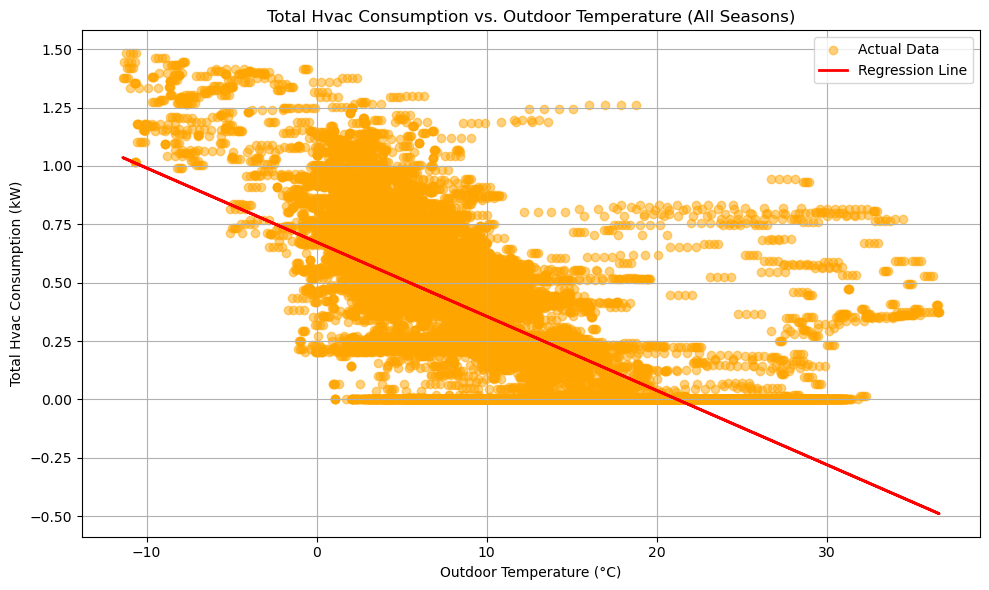

In [ ]:
def temp_vs_hvac_all_season(df:pd.DataFrame, weather:pd.DataFrame):
    weather_df['min_t'] = pd.to_datetime(weather_df['min_t'])
    weather_df['max_t'] = pd.to_datetime(weather_df['max_t'])

    # Option 1: Use start time's hour
    weather['hour'] = weather['min_t'].dt.hour


    # Option 2: Use the midpoint between start and end times
    weather['mid_t'] = weather['min_t'] + (weather['max_t'] - weather['min_t']) / 2
    weather['hour_mid'] = weather['mid_t'].dt.hour
    weather['date'] = weather['mid_t'].dt.date

    weather = weather.sort_values(by=['date', 'hour_mid']).reset_index(drop=True)


    df['date'] = pd.to_datetime(df['date']).dt.date

    df_weather_merged = pd.merge(
        df,
        weather_df[['wind_spd', 'temp', 'temp_f', 'dew_point', 'atm_pres', 'date', 'hour_mid']],
        left_on=['date', 'hour'],
        right_on=['date', 'hour_mid'],
        how='left'
    )

    df_weather_merged = df_weather_merged[['temp','hvac_total_kW']].dropna()

    X = df_weather_merged[['temp']]
    y = df_weather_merged['hvac_total_kW']
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"All Seasons - Mean Squared Error: {mse:.3f}")
    print(f"All Seasons - R-squared: {r2:.3f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='orange', alpha=0.5, label='Actual Data')
    plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Outdoor Temperature (°C)')
    plt.ylabel('Total Hvac Consumption (kW)')
    plt.title('Total Hvac Consumption vs. Outdoor Temperature (All Seasons)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
temp_vs_hvac_all_season(df,weather_df)